In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import numpy as np
from torch.utils.data import DataLoader

from model import MixingModel
from dataset import MultitrackAudioDataset
from inference_utils import mix_song
from medleydb_split import train_songlist, test_songlist

%load_ext autoreload
%autoreload 2

/home/apelykh/.virtualenvs/pytorch-audio/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

print(torch.backends.cudnn.version())
torch.backends.cudnn.benchmark = True

Torch version:  1.4.0
Device:  cuda
7603


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
weights_dir = './weights'
seed = 321
chunk_length = 4

In [4]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=train_songlist,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='train',
    seed=seed
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=train_songlist,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='val',
    seed=seed
)

d_test = MultitrackAudioDataset(
    base_path,
    songlist=test_songlist,
    chunk_length=chunk_length,
    train_val_test_split=(0.0, 0.0, 1.0),
    mode='test',
    seed=seed
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))
print('Test: {} tracks, {} chunks'.format(d_test.get_num_songs(), len(d_test)))

Train: 29 tracks, 1931 chunks
Val: 7 tracks, 508 chunks
Test: 31 tracks, 800 chunks


Train features shape:  (4, 128, 173)
265.17123 276.9652
[[268.86993 266.08032 265.70053 ... 265.17123 265.17123 265.8105 ]
 [268.2198  266.61356 266.3606  ... 265.17123 265.31754 266.48068]
 [268.3681  267.50714 267.4016  ... 267.03082 266.9746  267.3008 ]
 ...
 [265.17123 265.17123 265.17123 ... 265.17123 265.17123 265.17123]
 [265.17123 265.17123 265.17123 ... 265.17123 265.17123 265.17123]
 [265.17123 265.17123 265.17123 ... 265.17123 265.17123 265.17123]]
(128, 173)
------------------------------------------------------------
36.98244 38.842148
[[37.676212 37.710175 37.39551  ... 36.98244  36.98244  36.98244 ]
 [37.787907 37.76268  37.595604 ... 36.98244  37.03064  37.140915]
 [38.103634 38.031815 37.99463  ... 37.771206 37.725437 37.606888]
 ...
 [36.98244  36.98244  36.98244  ... 36.98244  36.98244  36.98244 ]
 [36.98244  36.98244  36.98244  ... 36.98244  36.98244  36.98244 ]
 [36.98244  36.98244  36.98244  ... 36.98244  36.98244  36.98244 ]]
(128, 173)


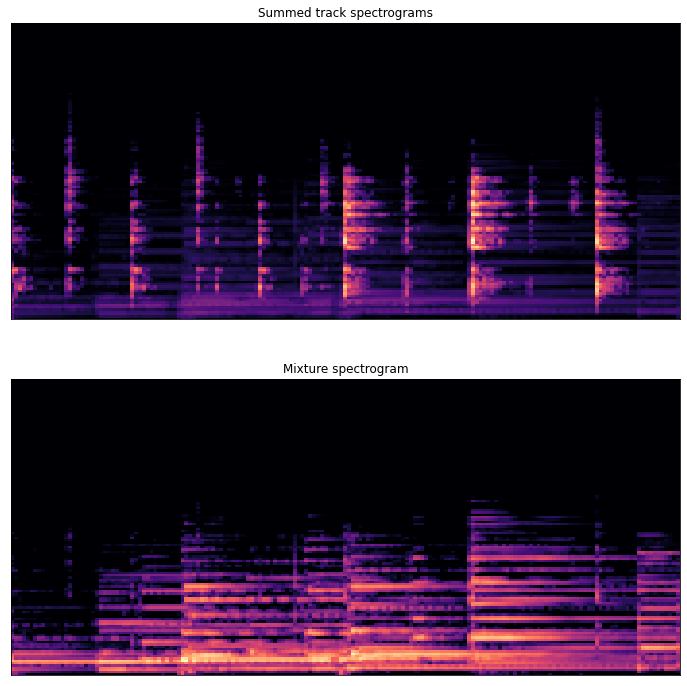

In [5]:
plt.figure(figsize=(12, 12))

sample = d_val[10]

print('Train features shape: ', sample['train_features'].shape)

summed_spec = sample['train_features'].sum(axis=0)

print(np.min(summed_spec), np.max(summed_spec))
print(summed_spec)

print(summed_spec.shape)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(summed_spec)
plt.title('Summed track spectrograms')

# -----------------------------------------------------------------
print('-' * 60)

print(np.min(sample['gt_features']), np.max(sample['gt_features']))
print(sample['gt_features'])

print(sample['gt_features'].shape)
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(sample['gt_features'])
plt.title('Mixture spectrogram')

plt.show()

In [ ]:
for i in range(len(d)):
    print('CHUNK: {}'.format(i))
    print('---------------')
    sample = d[i]
    if i == 20:
#         print(sample['drums_feature'].shape)
#         librosa.display.specshow(sample['mixture_feature'])
        ipd.Audio(sample['drums_audio'], rate=44100)
        print('---------------')
        break

In [11]:
train_loader = DataLoader(d_train, batch_size=32, shuffle=False,
                          num_workers=0, collate_fn=None,
                          pin_memory=False, drop_last=False, timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val, batch_size=219, shuffle=False,
                        num_workers=0, collate_fn=None,
                        pin_memory=False, drop_last=False, timeout=0,
                        worker_init_fn=None)

test_loader = DataLoader(d_test, batch_size=32, shuffle=False,
                        num_workers=0, collate_fn=None,
                        pin_memory=False, drop_last=False, timeout=0,
                        worker_init_fn=None)

---
### Defining and training the model

In [12]:
model = MixingModel().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

165660 trainable parameters


In [23]:
weights = './weights/mixmodel_bs136_0020_3.346.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [13]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def train_model(start_epoch, num_epochs):
    loss_hist = []

    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0

        for i, batch in enumerate(val_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            masked, masks = model(batch['train_features'].to(device))
    #         print(masked.shape)
    #         print(masks[0][0].shape)
    #         print(masks[0])
    #         masked_np = masked[0].detach().numpy()
    #         librosa.display.specshow(masked_np)

            loss = criterion(masked, batch['gt_features'].to(device))
            loss.backward()
            optimizer.step()

            each_n_batches = 1
            if i % each_n_batches == each_n_batches - 1:
                print('[%d, %4d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))

            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(val_loader)
        print('Epoch {} loss: {}\n'.format(epoch + 1, avg_epoch_loss))
        loss_hist.append(avg_epoch_loss)
    
    return loss_hist

In [15]:
start_epoch = 0
num_epochs = 30
loss_hist = train_model(start_epoch, num_epochs)

[1,    1] loss: 1521.985
[1,    2] loss: 5834.629
Epoch 1 loss: 3678.3071899414062

[2,    1] loss: 146.007
[2,    2] loss: 474.566
Epoch 2 loss: 310.28646087646484

[3,    1] loss: 503.341
[3,    2] loss: 540.745
Epoch 3 loss: 522.0429840087891

[4,    1] loss: 346.453
[4,    2] loss: 331.596
Epoch 4 loss: 339.0248107910156

[5,    1] loss: 147.175
[5,    2] loss: 376.624
Epoch 5 loss: 261.8991241455078

[6,    1] loss: 39.770
[6,    2] loss: 266.479
Epoch 6 loss: 153.12462615966797

[7,    1] loss: 31.962
[7,    2] loss: 183.175
Epoch 7 loss: 107.56864738464355

[8,    1] loss: 50.825
[8,    2] loss: 171.347
Epoch 8 loss: 111.08597564697266

[9,    1] loss: 62.853
[9,    2] loss: 160.801
Epoch 9 loss: 111.82733154296875

[10,    1] loss: 66.501
[10,    2] loss: 159.876
Epoch 10 loss: 113.18855285644531

[11,    1] loss: 57.592
[11,    2] loss: 159.164
Epoch 11 loss: 108.37800216674805

[12,    1] loss: 46.918
[12,    2] loss: 157.349
Epoch 12 loss: 102.1334457397461

[13,    1] loss:

In [50]:
loss_hist2 = train_model(60, 30)

[61,    1] loss: 23.504
[61,    2] loss: 104.376
Epoch 61 loss: 63.93983554840088

[62,    1] loss: 17.879
[62,    2] loss: 111.015
Epoch 62 loss: 64.44704627990723

[63,    1] loss: 22.088
[63,    2] loss: 104.613
Epoch 63 loss: 63.35036754608154

[64,    1] loss: 21.561
[64,    2] loss: 105.925
Epoch 64 loss: 63.742981910705566

[65,    1] loss: 20.795
[65,    2] loss: 101.892
Epoch 65 loss: 61.34375190734863

[66,    1] loss: 21.979
[66,    2] loss: 101.646
Epoch 66 loss: 61.812384605407715

[67,    1] loss: 19.379
[67,    2] loss: 102.803
Epoch 67 loss: 61.091416358947754

[68,    1] loss: 17.200
[68,    2] loss: 103.903
Epoch 68 loss: 60.55133056640625

[69,    1] loss: 19.991
[69,    2] loss: 104.816
Epoch 69 loss: 62.4036922454834

[70,    1] loss: 21.896
[70,    2] loss: 101.003
Epoch 70 loss: 61.44980239868164

[71,    1] loss: 21.073
[71,    2] loss: 107.435
Epoch 71 loss: 64.25425243377686

[72,    1] loss: 21.982
[72,    2] loss: 108.107
Epoch 72 loss: 65.0445032119751

[73

In [51]:
weights_file = os.path.join(weights_dir, 'mixmodel_bs{}_{:04d}_{:.3f}.pt'.format(219, 90, 53.6325)) 
torch.save(model.state_dict(), weights_file)

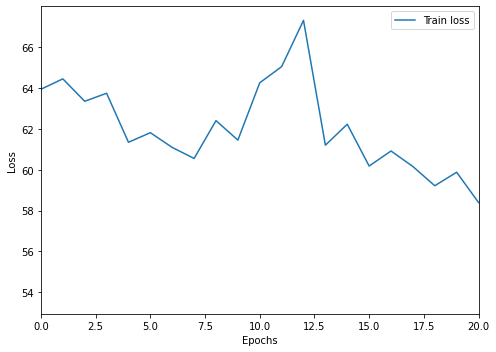

In [52]:
plt.figure(figsize=(7,5))
plt.plot(loss_hist2, label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 0 + 20)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

---
## Model Inference

In [ ]:
song = d_val[20]
print('Song index: ', song['song_index'])
print('Song name: ', song['song_name'])

sum_audio = np.zeros_like(song['mix_audio'])

for track in d_test._tracklist:
    if track != 'mix':
        sum_audio += song['{}_audio'.format(track)]

ipd.Audio(sum_audio, rate=44100)

In [ ]:
ipd.Audio(song['mix_audio'], rate=44100)

In [57]:
features = torch.Tensor(song['train_features'][np.newaxis, :])
masked, masks = model(features.to(device))

res = masked.to('cpu').detach().numpy()
print(res[0])

[[21.735252 21.148886 21.32511  ... 22.830427 22.220718 21.086496]
 [21.80348  21.201454 21.399012 ... 22.919212 22.311245 21.141008]
 [21.775227 21.112635 21.310333 ... 22.879688 22.312504 21.12926 ]
 ...
 [21.538845 20.8385   21.113447 ... 22.595303 22.093851 20.972706]
 [21.538845 20.8385   21.113447 ... 22.595303 22.093851 20.972706]
 [21.538845 20.8385   21.113447 ... 22.595303 22.093851 20.972706]]


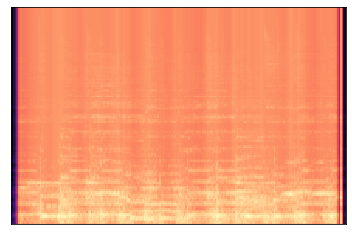

In [58]:
librosa.display.specshow(res[0])

---
### Mixing the full song

In [ ]:
song_name = 'SweetLights_YouLetMeDown'

loaded_tracks = {}

for track in d_train.get_tracklist():
    if track == 'mix':
        track_path = os.path.join(base_path, song_name, '{}_MIX.wav'.format(song_name))
    else:
        track_path = os.path.join(base_path, song_name, '{}_STEMS_JOINED'.format(song_name),
                                  '{}_STEM_{}.wav'.format(song_name, track.upper()))

    print('Loading {}'.format(track))
    loaded_tracks[track], _ = librosa.load(track_path, sr=44100)

In [ ]:
# ground truth
ipd.Audio(loaded_tracks['mix'], rate=44100)

In [ ]:
# summed tracks, no mix
sum_audio = np.zeros_like(loaded_tracks['mix'])

for track in d_train.get_tracklist():
    if track != 'mix':
        print('Summing {}'.format(track))
        sum_audio += loaded_tracks['{}'.format(track)]

ipd.Audio(sum_audio, rate=44100)

In [32]:
print(d_val.songlist)

['CroqueMadame_Pilot', 'ClaraBerryAndWooldog_Stella', 'FamilyBand_Again', 'AvaLuna_Waterduct', 'SweetLights_YouLetMeDown', 'AlexanderRoss_GoodbyeBolero', 'FacesOnFilm_WaitingForGa']


In [ ]:
# model result
mixed_song = mix_song(d_train, model, loaded_tracks, dummy_masks=False)
ipd.Audio(mixed_song, rate=44100)